# Surgery Pipeline for query data with new celltypes with SCANVI

In [1]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown

In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

## Set relevant anndata.obs labels and training length

Here we use the CelSeq2 and SS2 studies as query data and the other 3 studies as reference atlas.
We strongly suggest to use earlystopping to avoid over-fitting. The best earlystopping criteria are the 'elbo' for SCVI pretraining and also for unlabelled surgery training and 'accurarcy' for semi-supervised SCANVI training.

In [4]:
condition_key = 'condition'
cell_type_key = 'final_annotation'
target_conditions = ['Sun', 'Freytag']

vae_epochs = 500
scanvi_epochs = 200
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 10,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}
early_stopping_kwargs_scanvi = {
    "early_stopping_metric": "accuracy",
    "save_best_state_metric": "accuracy",
    "on": "full_dataset",
    "patience": 10,
    "threshold": 0.001,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}
early_stopping_kwargs_surgery = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "on": "full_dataset",
    "patience": 10,
    "threshold": 0.001,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}

## Download Dataset and split into reference dataset and query dataset

In [5]:
url = 'https://drive.google.com/uc?id=1UazsSNn92Z4cuQ2XUDuVymGjSJPnnp3F'
output = 'pbmc.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1UazsSNn92Z4cuQ2XUDuVymGjSJPnnp3F
To: /home/marco/Documents/aaa_dev_mars/scarches/pbmc.h5ad
164MB [00:01, 97.0MB/s] 


'pbmc.h5ad'

In [6]:
adata_all = sc.read('pbmc.h5ad')

In [7]:
adata = adata_all.raw.to_adata()
adata = remove_sparsity(adata)
source_adata = adata[~adata.obs.study.isin(target_conditions)].copy()
target_adata = adata[adata.obs.study.isin(target_conditions)].copy()

In [8]:
source_adata

AnnData object with n_obs × n_vars = 12186 × 4000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'condition'

In [9]:
target_adata

AnnData object with n_obs × n_vars = 8336 × 4000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'condition'

## Create SCANVI model and train it on fully labelled reference dataset

In [10]:
sca.dataset.setup_anndata(source_adata, batch_key=condition_key, labels_key=cell_type_key)

INFO     Using batches from adata.obs["condition"]                                           
INFO     Using labels from adata.obs["final_annotation"]                                     
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 12186 cells, 4000 vars, 4 batches,
         14 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        
INFO     Please do not further modify adata until model is trained.                          


The parameters chosen here proofed to work best in the case of surgery with SCANVI.

In [11]:
vae = sca.models.SCANVI(
    source_adata,
    "Unknown",
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
)

In [12]:
print("Labelled Indices: ", len(vae._labeled_indices))
print("Unlabelled Indices: ", len(vae._unlabeled_indices))

Labelled Indices:  12186
Unlabelled Indices:  0


In [13]:
vae.train(
    n_epochs_unsupervised=vae_epochs,
    n_epochs_semisupervised=scanvi_epochs,
    unsupervised_trainer_kwargs=dict(early_stopping_kwargs=early_stopping_kwargs),
    semisupervised_trainer_kwargs=dict(metrics_to_monitor=["elbo", "accuracy"],
                                       early_stopping_kwargs=early_stopping_kwargs_scanvi),
    frequency=1
)

INFO     Training Unsupervised Trainer for 500 epochs.                                       
INFO     Training SemiSupervised Trainer for 200 epochs.                                     
INFO     KL warmup for 400 epochs                                                            
Training...:  30%|██▉       | 148/500 [01:54<04:29,  1.31it/s]INFO                                                                                         
         Stopping early: no improvement of more than 0 nats in 10 epochs                     
INFO     If the early stopping criterion is too strong, please instantiate it with different 
         parameters in the train method.                                                     
Training...:  30%|██▉       | 148/500 [01:55<04:34,  1.28it/s]
INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Training time:  80 s

## Create anndata file of latent representation and compute UMAP

In [14]:
reference_latent = sc.AnnData(vae.get_latent_representation())
reference_latent.obs["celltype"] = source_adata.obs[cell_type_key].tolist()
reference_latent.obs["batch"] = source_adata.obs[condition_key].tolist()

... storing 'celltype' as categorical
... storing 'batch' as categorical


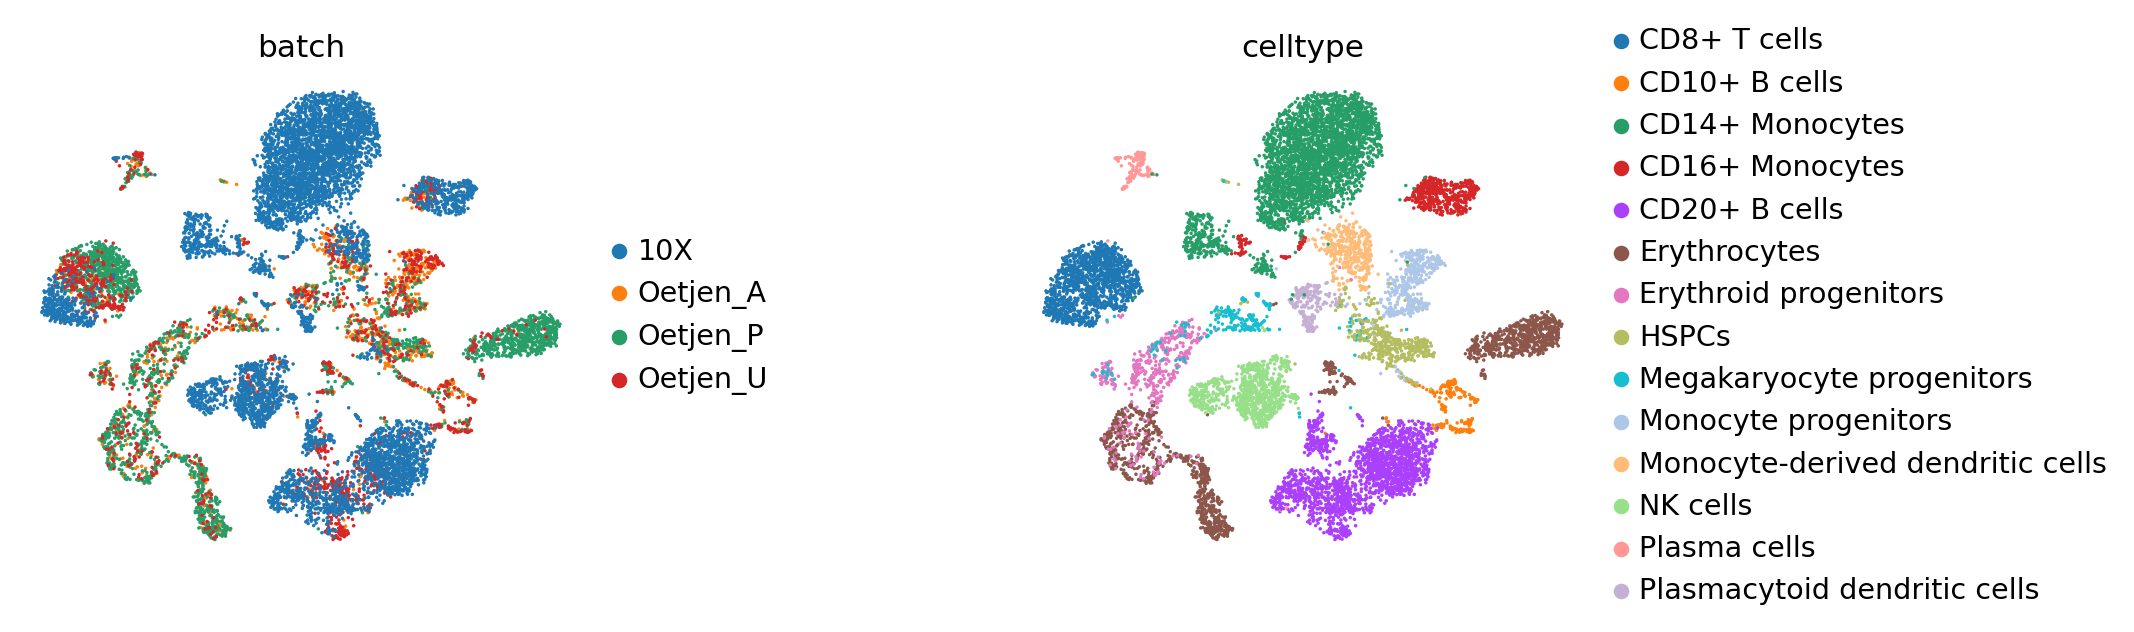

In [15]:
sc.pp.neighbors(reference_latent, n_neighbors=8)
sc.tl.leiden(reference_latent)
sc.tl.umap(reference_latent)
sc.pl.umap(reference_latent,
           color=['batch', 'celltype'],
           frameon=False,
           wspace=0.6,
           )

One can also compute the accuracy of the learned classifier

In [16]:
reference_latent.obs['predictions'] = vae.predict()
print("Acc: {}".format(np.mean(reference_latent.obs.predictions == reference_latent.obs.celltype)))

Acc: 0.9658624651239127


After pretraining the model can be saved for later use

In [17]:
ref_path = 'ref_model/'
vae.save(ref_path, overwrite=True)

## Perform surgery on reference model and train on query dataset without cell type labels

In [18]:
target_adata.obs['orig_cell_types'] = target_adata.obs[cell_type_key].copy()
print(target_adata.obs['orig_cell_types'].unique().tolist())
target_adata.obs[cell_type_key] = vae.unlabeled_category_
print(target_adata.obs[cell_type_key].unique().tolist())
print(target_adata.obs['orig_cell_types'].unique().tolist())

['CD8+ T cells', 'NKT cells', 'NK cells', 'CD20+ B cells', 'Megakaryocyte progenitors', 'Plasmacytoid dendritic cells', 'CD16+ Monocytes', 'CD4+ T cells', 'Monocyte-derived dendritic cells']
['Unknown']
['CD8+ T cells', 'NKT cells', 'NK cells', 'CD20+ B cells', 'Megakaryocyte progenitors', 'Plasmacytoid dendritic cells', 'CD16+ Monocytes', 'CD4+ T cells', 'Monocyte-derived dendritic cells']


In [19]:
model = sca.models.SCANVI.load_query_data(
    target_adata,
    ref_path,
    freeze_dropout = True,
)
model._unlabeled_indices = np.arange(target_adata.n_obs)
model._labeled_indices = []
print("Labelled Indices: ", len(model._labeled_indices))
print("Unlabelled Indices: ", len(model._unlabeled_indices))

INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 8336 cells, 4000 vars, 9 batches, 
         15 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        
Labelled Indices:  0
Unlabelled Indices:  8336


In [20]:
model.train(
    n_epochs_semisupervised=surgery_epochs,
    train_base_model=False,
    semisupervised_trainer_kwargs=dict(metrics_to_monitor=["accuracy", "elbo"], 
                                       weight_decay=0,
                                       early_stopping_kwargs=early_stopping_kwargs_surgery
                                      ),
    frequency=1
)

INFO     Training Unsupervised Trainer for 400 epochs.                                       
INFO     Training SemiSupervised Trainer for 500 epochs.                                     
INFO     KL warmup for 400 epochs                                                            
Training...:  28%|██▊       | 141/500 [04:01<10:34,  1.77s/it]INFO                                                                                         
         Stopping early: no improvement of more than 0.001 nats in 10 epochs                 
INFO     If the early stopping criterion is too strong, please instantiate it with different 
         parameters in the train method.                                                     
Training...:  28%|██▊       | 141/500 [04:02<10:18,  1.72s/it]
INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Training time:  98 s

In [21]:
query_latent = sc.AnnData(model.get_latent_representation())
query_latent.obs['celltype'] = target_adata.obs['orig_cell_types'].tolist()
query_latent.obs['batch'] = target_adata.obs[condition_key].tolist()

... storing 'celltype' as categorical
... storing 'batch' as categorical


<Figure size 320x320 with 0 Axes>

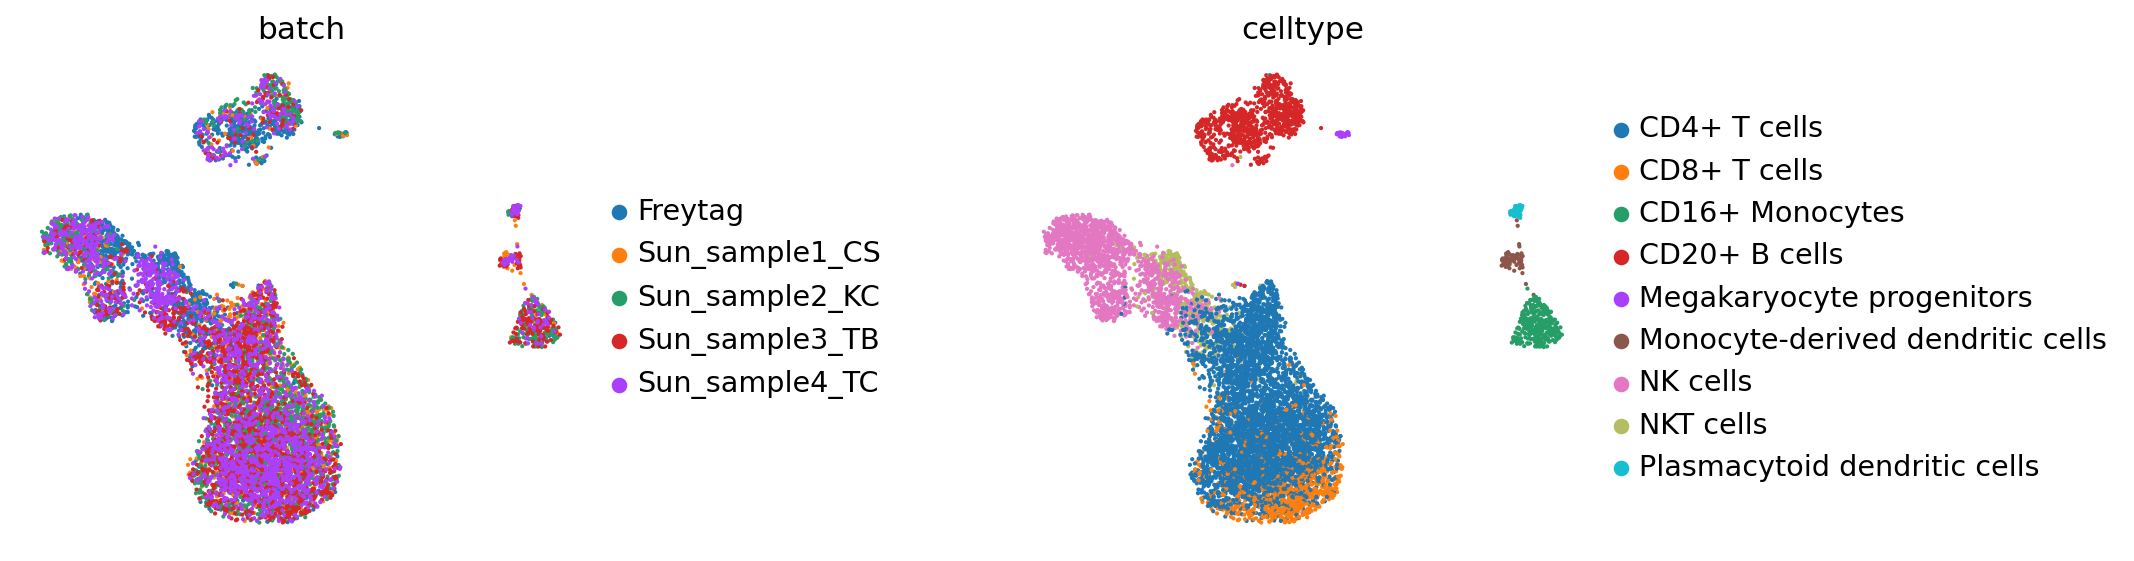

In [22]:
sc.pp.neighbors(query_latent)
sc.tl.leiden(query_latent)
sc.tl.umap(query_latent)
plt.figure()
sc.pl.umap(
    query_latent,
    color=["batch", "celltype"],
    frameon=False,
    wspace=0.6,
)

In [23]:
surgery_path = 'surgery_model'
model.save(surgery_path, overwrite=True)

## Compute Accuracy of model classifier for query dataset and compare predicted and observed cell types

In [24]:
query_latent.obs['predictions'] = model.predict()
print("Acc: {}".format(np.mean(query_latent.obs.predictions == query_latent.obs.celltype)))

Acc: 0.4226247600767754


Text(0, 0.5, 'Observed')

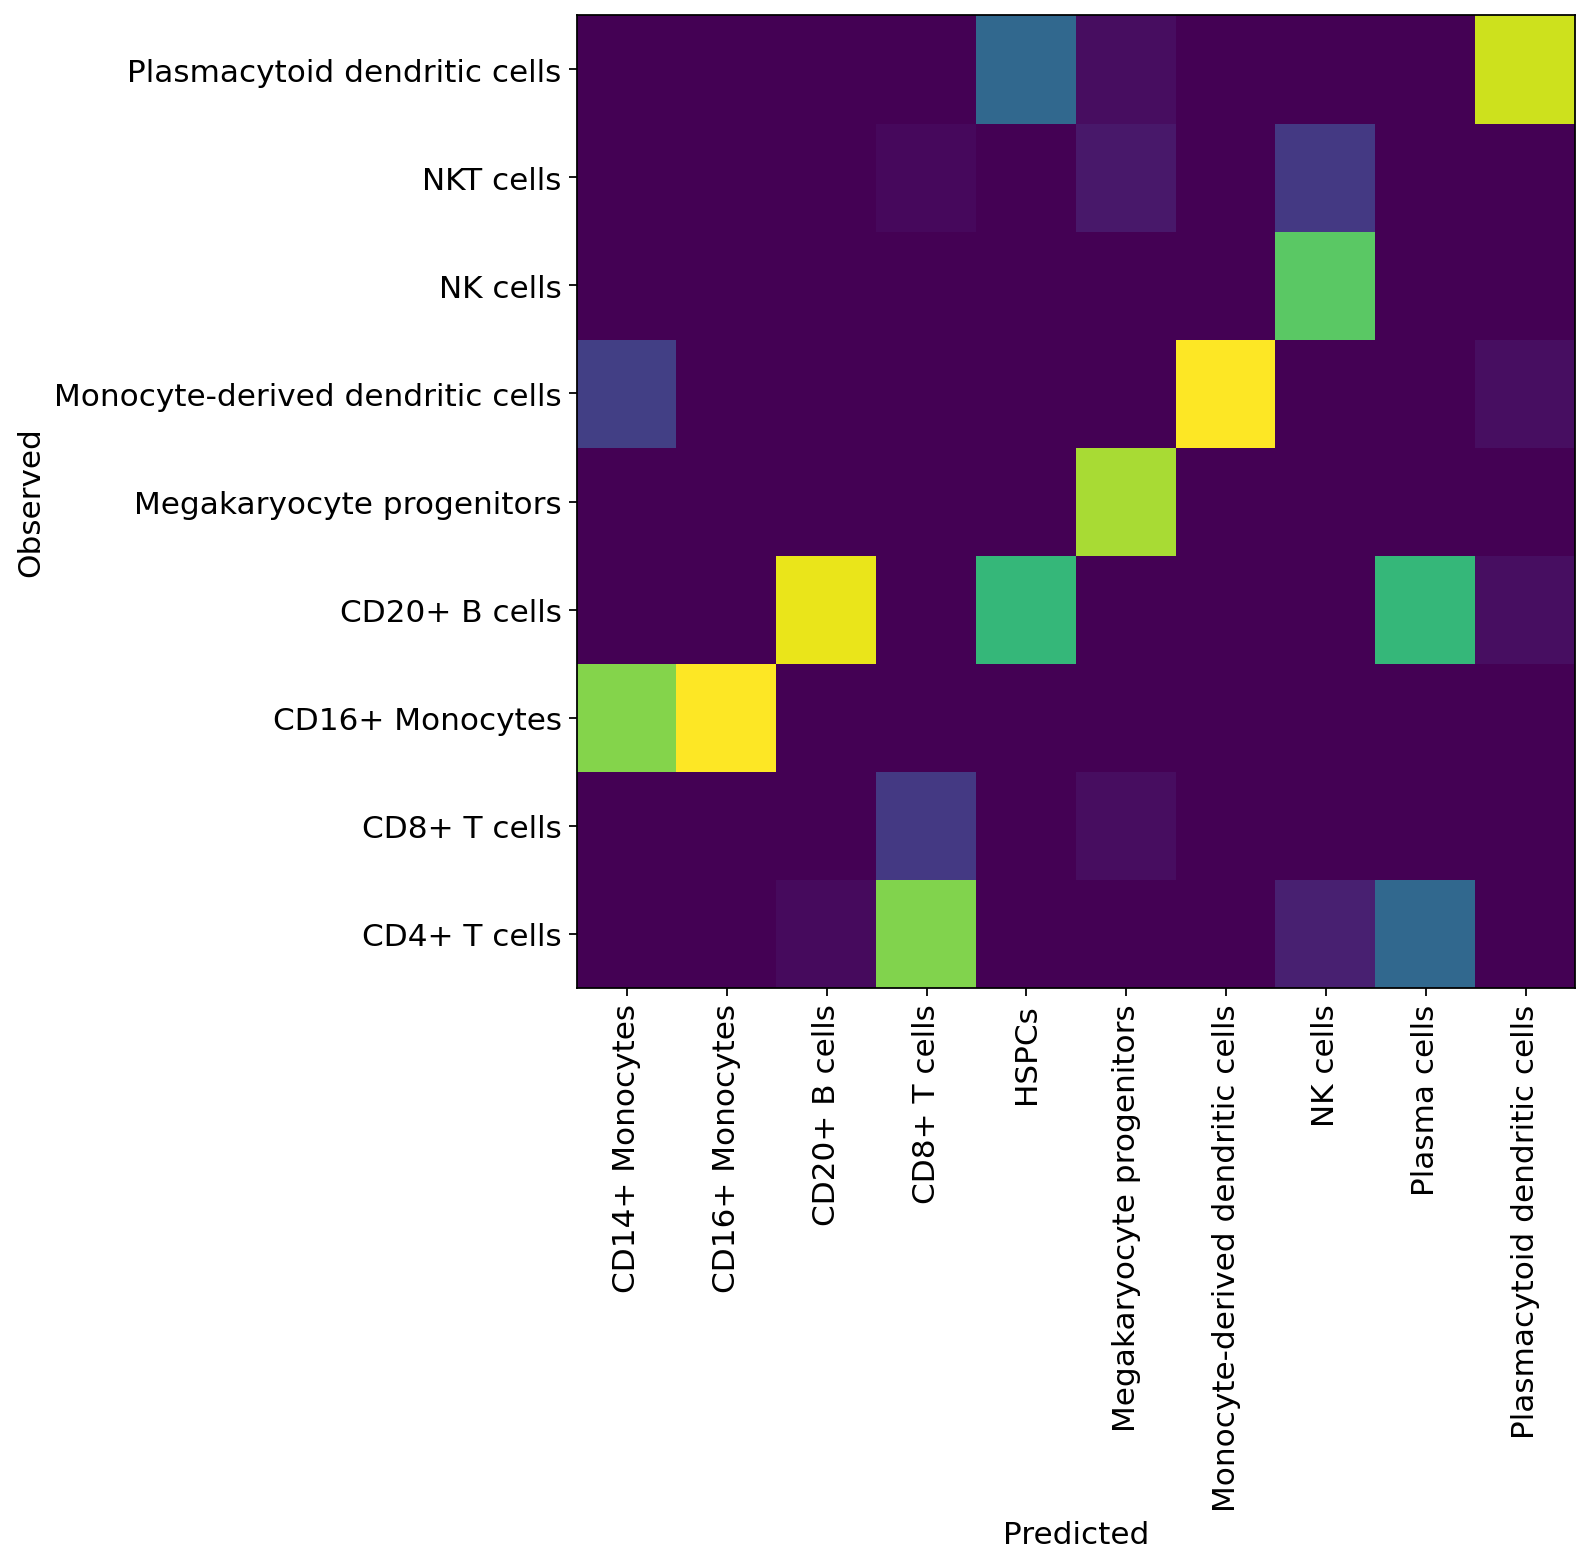

In [25]:
df = query_latent.obs.groupby(["celltype", "predictions"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

## Get latent representation of reference + query dataset and compute UMAP

In [26]:
adata_full = source_adata.concatenate(target_adata)
full_latent = sc.AnnData(model.get_latent_representation(adata=adata_full))
full_latent.obs['celltype'] = adata_full.obs[cell_type_key].tolist()
full_latent.obs['batch'] = adata_full.obs[condition_key].tolist()

INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 20522 cells, 4000 vars, 9 batches,
         15 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        


... storing 'celltype' as categorical
... storing 'batch' as categorical


<Figure size 320x320 with 0 Axes>

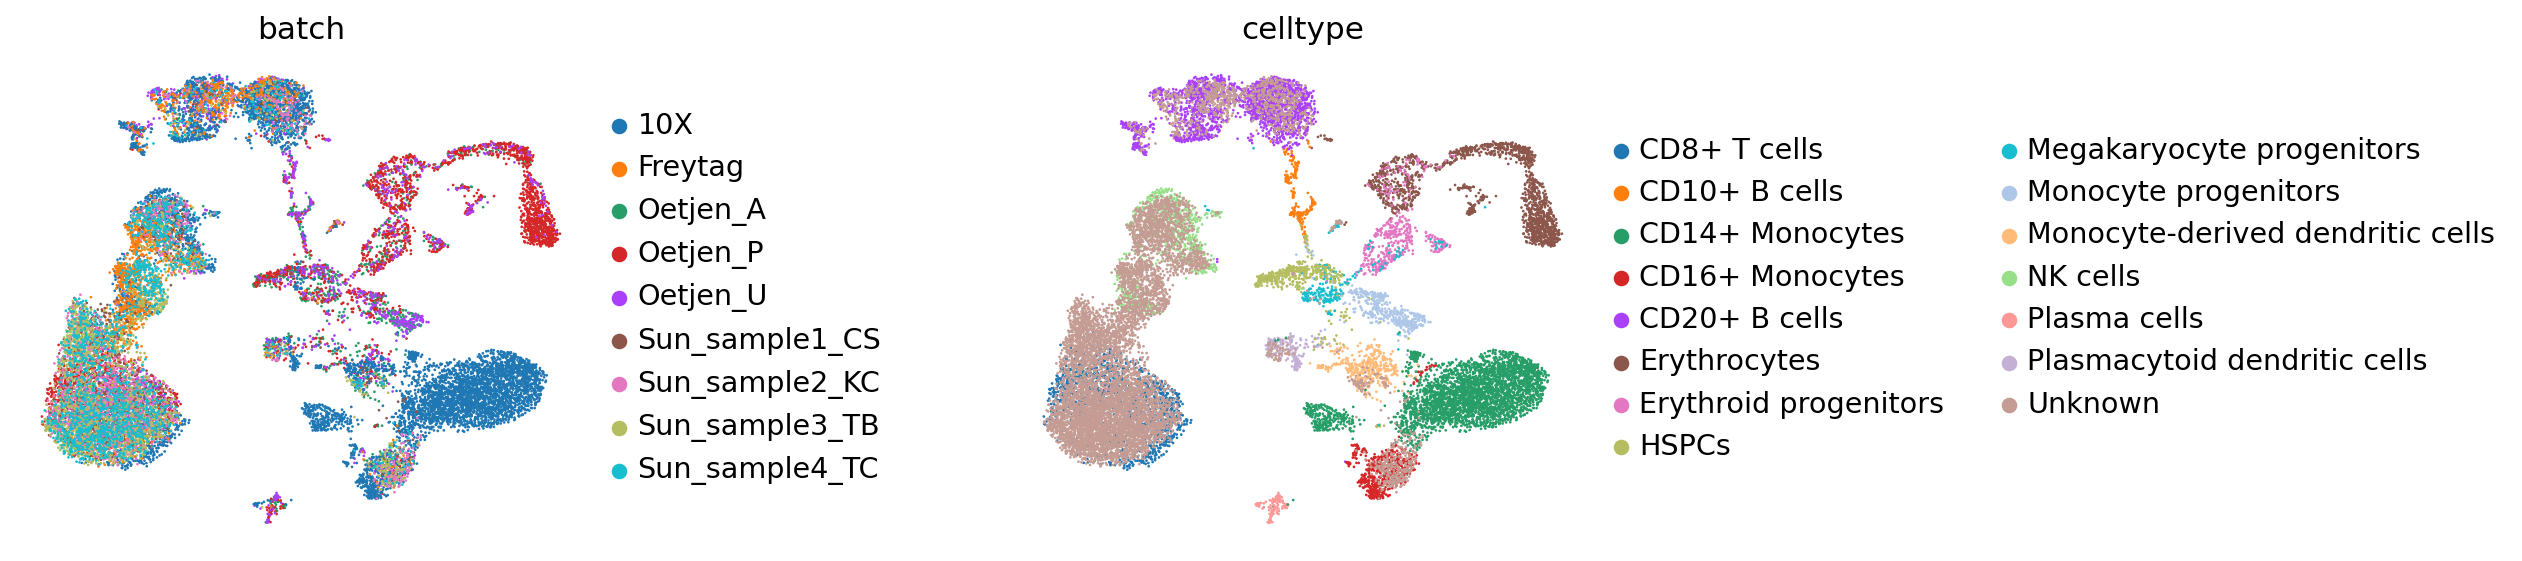

In [27]:
sc.pp.neighbors(full_latent)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)
plt.figure()
sc.pl.umap(
    full_latent,
    color=["batch", "celltype"],
    frameon=False,
    wspace=0.6,
)

## Comparison of observed and predicted celltypes for reference + query dataset

In [28]:
full_latent.obs['predictions'] = model.predict(adata=adata_full)
print("Acc: {}".format(np.mean(full_latent.obs.predictions == full_latent.obs.celltype)))

Acc: 0.5735308449468862


... storing 'predictions' as categorical


<Figure size 320x320 with 0 Axes>

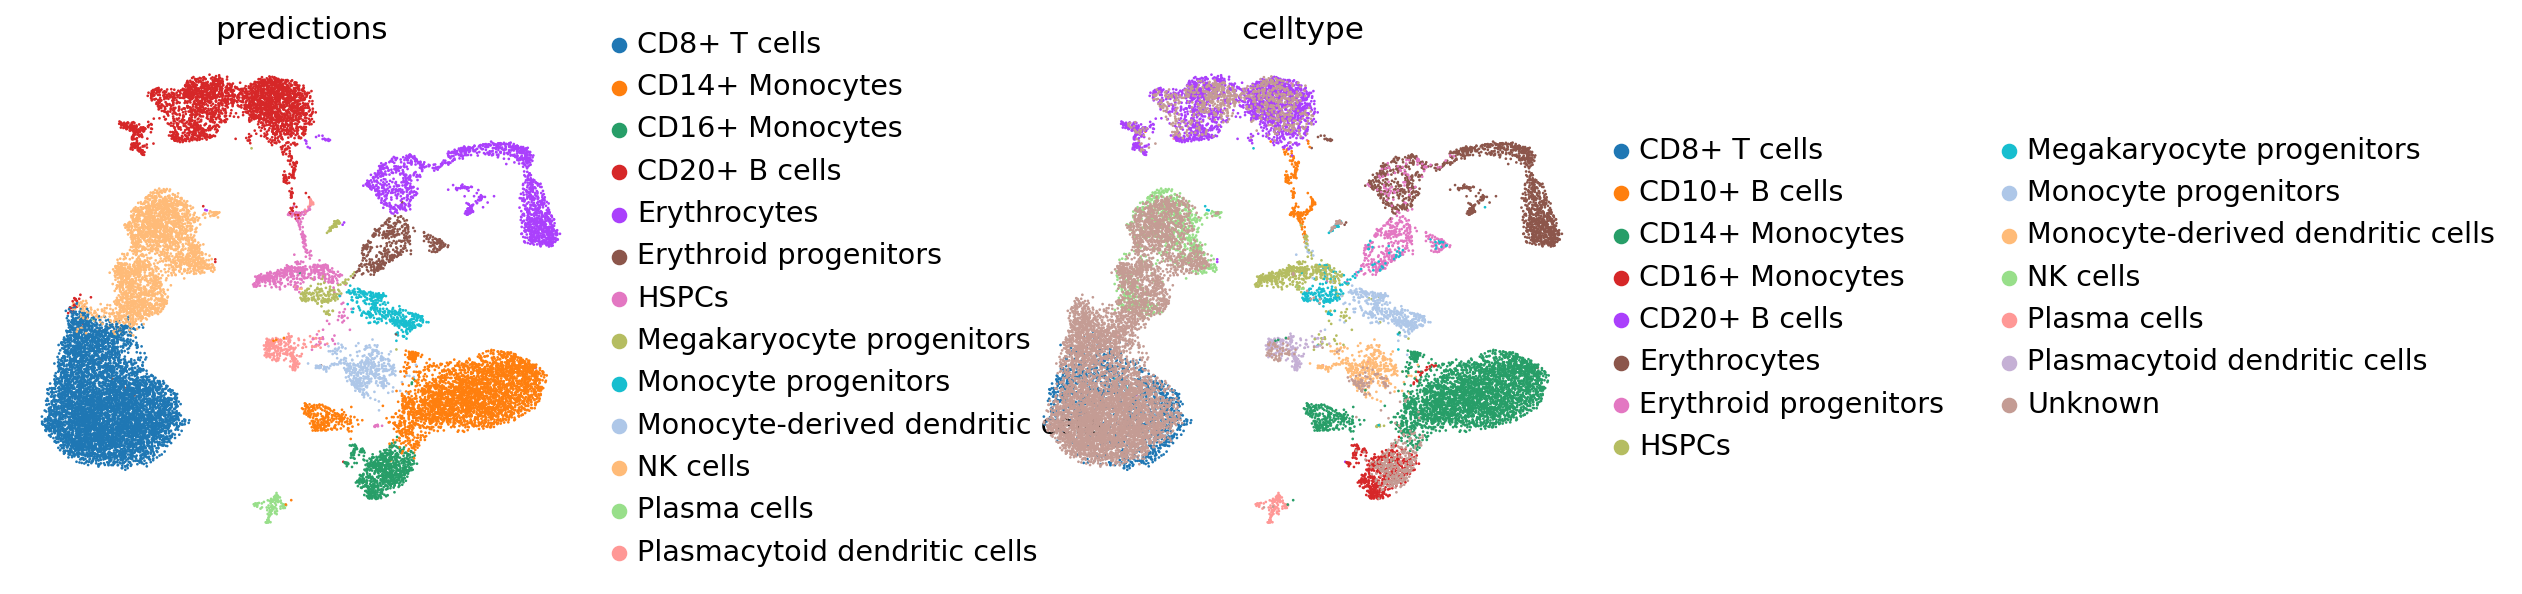

In [29]:
sc.pp.neighbors(full_latent)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)
plt.figure()
sc.pl.umap(
    full_latent,
    color=["predictions", "celltype"],
    frameon=False,
    wspace=0.6,
)